<a href="https://colab.research.google.com/github/jyotidabass/Prediction-of-clothing-size/blob/main/clothing_size_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Description:** Machine learning model used to predict women's clothing sizes based on historical data on age, weight and height

## 1. Problem definition
> How well can we predict the appropriate clothing size of for an individual, given age, weight and height?

## 2. Data
The data file for this project `final_test.csv` can be downloaded from the clothing-size prediction dataset on Kaggle : https://www.kaggle.com/tourist55/clothessizeprediction

   
## 3. Evaluation 

> **Goal:** Predict the clothing size of an individual with >95% accuracy

## 4. Features

* weight (kg)
* age (years)
* height (cm)

### Import libraries

In [1]:
!git clone https://github.com/koulkoudakis/clothing-size-predictor.git

Cloning into 'clothing-size-predictor'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 0), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [2]:
# Regular EDA (exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Models from Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

### Import data

In [3]:
df_raw = pd.read_csv("/content/clothing-size-predictor/data/final_test.csv")
df_raw

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M
...,...,...,...,...
119729,63,42.0,175.26,M
119730,45,29.0,154.94,S
119731,61,31.0,172.72,M
119732,74,31.0,167.64,XL


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119734 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119734 non-null  int64  
 1   age     119477 non-null  float64
 2   height  119404 non-null  float64
 3   size    119734 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


### Exploratory data analysis (EDA)

In [5]:
df_raw.describe()

,weight,age,height
count,119734.000000,119477.000000,119404.000000
mean,61.756811,34.027311,165.805794
std,9.944863,8.149447,6.737651
min,22.000000,0.000000,137.160000
25%,55.000000,29.000000,160.020000
50%,61.000000,32.000000,165.100000
75%,67.000000,37.000000,170.180000
max,136.000000,117.000000,193.040000


In [6]:
# Number of occurences for each size (target variable)
df_raw["size"].value_counts()

M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
Name: size, dtype: int64

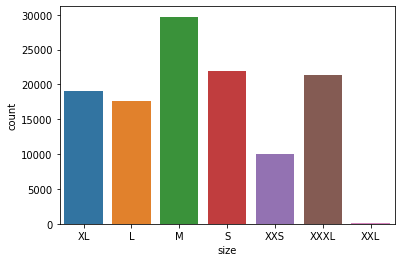

In [7]:
# Number of occurences for each size (target variable)
sns.countplot(x=df_raw["size"])

Size `M` is the most common

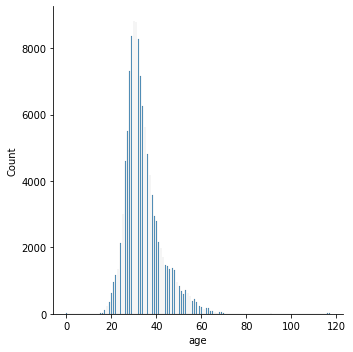

In [8]:
# Age distribution
sns.displot(df_raw["age"])

Large fraction of population seems to be around the ages of `25 to 35 years old`

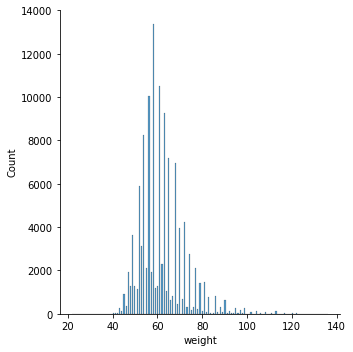

In [9]:
# Weight distribution
sns.displot(df_raw["weight"])

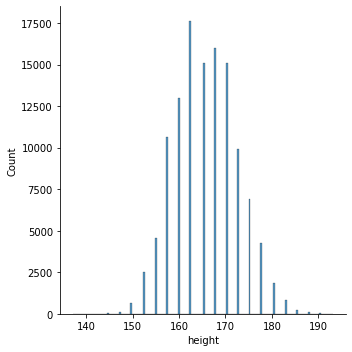

In [10]:
# height distribution
sns.displot(df_raw["height"])

Population weight and height seem to show reasonable normal distributions

### Removing outliers (z-score)

In [11]:
# Removing Outliers
dfs = []
sizes = []
for size_type in df_raw['size'].unique():
    sizes.append(size_type)
    ndf = df_raw[['age','height','weight']][df_raw['size'] == size_type]
    zscore = ((ndf - ndf.mean())/ndf.std())
    dfs.append(zscore)
    
for i in range(len(dfs)):
    dfs[i]['age'] = dfs[i]['age'][(dfs[i]['age']>-3) & (dfs[i]['age']<3)]
    dfs[i]['height'] = dfs[i]['height'][(dfs[i]['height']>-3) & (dfs[i]['height']<3)]
    dfs[i]['weight'] = dfs[i]['weight'][(dfs[i]['weight']>-3) & (dfs[i]['weight']<3)]

for i in range(len(sizes)):
    dfs[i]['size'] = sizes[i]
df_raw = pd.concat(dfs)
df_raw.head()

,age,height,weight,size
0,-0.833326,0.767729,-0.660757,XL
24,-0.713290,1.539527,1.556338,XL
25,-0.353183,-1.161765,-0.291241,XL
28,-0.473219,-1.933562,-1.399788,XL
34,0.126960,-0.775866,0.447791,XL


### Filling missing data

In [12]:
# Check for missing values
df_raw.isna().sum()

age       1678
height     547
weight    1069
size         0
dtype: int64

In [13]:
# Filling missing data
df_raw["age"] = df_raw["age"].fillna(df_raw['age'].median())
df_raw["height"] = df_raw["height"].fillna(df_raw['height'].median())
df_raw["weight"] = df_raw["weight"].fillna(df_raw['weight'].median())

In [14]:
# Mapping clothes size from strings to numeric
df_raw['size'] = df_raw['size'].map({"XXS": 1,
                                     "S": 2,
                                     "M" : 3,
                                     "L" : 4,
                                     "XL" : 5,
                                     "XXL" : 6,
                                     "XXXL" : 7})

In [15]:
# Check for missing values
df_raw.isna().sum()

age       0
height    0
weight    0
size      0
dtype: int64

In [16]:
df_raw

,age,height,weight,size
0,-0.833326,0.767729,-0.660757,5
24,-0.713290,1.539527,1.556338,5
25,-0.353183,-1.161765,-0.291241,5
28,-0.473219,-1.933562,-1.399788,5
34,0.126960,-0.775866,0.447791,5
...,...,...,...,...
112707,-1.236027,-1.489537,0.318135,6
114732,-0.633300,-0.052082,1.494100,6
114803,-0.432391,-0.052082,0.514129,6
114994,0.973972,-0.052082,-0.465841,6


### Feature Engineering
We will create two new features to help model training effectiveness:
* `bmi` (body-mass index) - medically accepted measure of obesity
* `weight-squared` - value increases exponentially with increase in `weight`

In [17]:
df_raw["bmi"] = df_raw["height"]/df_raw["weight"]
df_raw["weight-squared"] = df_raw["weight"] * df_raw["weight"]

In [18]:
df_raw

,age,height,weight,size,bmi,weight-squared
0,-0.833326,0.767729,-0.660757,5,-1.161894,0.436599
24,-0.713290,1.539527,1.556338,5,0.989198,2.422189
25,-0.353183,-1.161765,-0.291241,5,3.989017,0.084821
28,-0.473219,-1.933562,-1.399788,5,1.381325,1.959407
34,0.126960,-0.775866,0.447791,5,-1.732653,0.200517
...,...,...,...,...,...,...
112707,-1.236027,-1.489537,0.318135,6,-4.682086,0.101210
114732,-0.633300,-0.052082,1.494100,6,-0.034858,2.232334
114803,-0.432391,-0.052082,0.514129,6,-0.101301,0.264329
114994,0.973972,-0.052082,-0.465841,6,0.111801,0.217008


### Correlation matrix

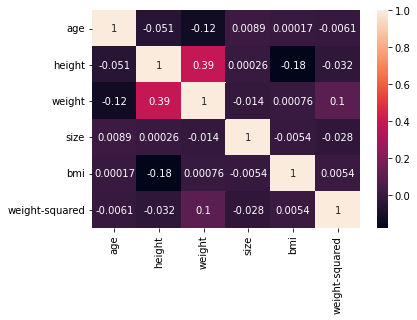

In [19]:
corr = sns.heatmap(df_raw.corr(), annot=True)

Clothing `size` seems much more highly dependent on `weight` than `age` or `height`, and seems to be have a strong inverse correlation with `bmi`

### Splitting data into training and validation datasets
The target variable is clothing `size`, and we will let the validation set be 10% of the total population.

In [20]:
# Features
X = df_raw.drop("size", axis=1)

# Target
y = df_raw["size"]

In [21]:
X.head()

,age,height,weight,bmi,weight-squared
0,-0.833326,0.767729,-0.660757,-1.161894,0.436599
24,-0.713290,1.539527,1.556338,0.989198,2.422189
25,-0.353183,-1.161765,-0.291241,3.989017,0.084821
28,-0.473219,-1.933562,-1.399788,1.381325,1.959407
34,0.126960,-0.775866,0.447791,-1.732653,0.200517


In [22]:
y.head()

0     5
24    5
25    5
28    5
34    5
Name: size, dtype: int64

In [23]:
# Splitting data into training set and validation set

X_train, X_test, y_train, y_test, = train_test_split(X,y, test_size=0.10)

In [24]:
len(X_train), len(X_test)

(107760, 11974)

### Training Model
We will try:
* Logistic Regression
* K-Nearest Neighbors
* Random Forest Classifier
* Decision Tree Classifier

In [25]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "Decision Tree": DecisionTreeClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
   
    """
   Fits and evaluates given machine learning models.
   models: a dict of different Scikit_Learn machine learning models
   X_train: training data (no labels)
   X_test: testing data (no labels)
   y_train: training labels
   y_test: test labels
   """ 
    # Set random seed
    np.random.seed(18)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit model to data
        model.fit(X_train, y_train)
        # Evaluate model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)

    return model_scores

In [26]:
model_scores = fit_and_score(models,
                            X_train,
                             X_test,
                             y_train,
                             y_test)

model_scores

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


{'Decision Tree': 0.9996659428762318,
 'KNN': 0.898363120093536,
 'Logistic Regression': 0.24561550025054285,
 'Random Forest': 0.9985802572239854}

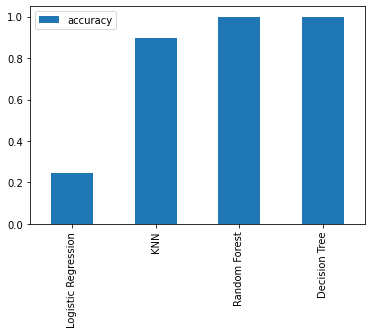

In [27]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

### Model evaluation
We will continue with the DecisionTreeClassifier model, which scored highest in initial tests with `99.9749%` accuracy.


In [28]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [29]:
# Confusion matrix
print(confusion_matrix(y_test, y_pred))

[[ 983    0    0    0    0    0    0]
 [   0 2186    0    0    1    0    0]
 [   0    0 2940    0    0    0    0]
 [   0    0    0 1728    0    0    0]
 [   0    0    0    0 1969    0    0]
 [   0    0    0    0    0    4    1]
 [   1    0    1    0    0    0 2160]]


In [30]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       983
           2       1.00      1.00      1.00      2187
           3       1.00      1.00      1.00      2940
           4       1.00      1.00      1.00      1728
           5       1.00      1.00      1.00      1969
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00      2162

    accuracy                           1.00     11974
   macro avg       1.00      0.97      0.98     11974
weighted avg       1.00      1.00      1.00     11974



### Conclusion

The trained model shows a weighted average accuracy of `99.9%`, so the evaluation metric of >95% has been met.

### Feature Importance

In [31]:
# Find feature importance of ideal model
len(model.feature_importances_)

5

In [32]:
model.feature_importances_

array([6.52400154e-04, 5.37753567e-03, 2.81105869e-01, 1.01635644e-02,
       7.02700631e-01])

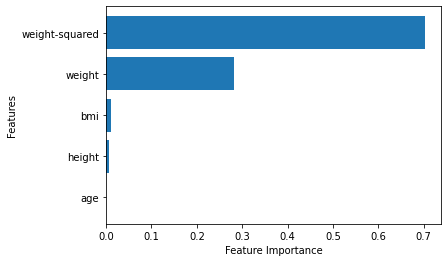

In [33]:
# Helper function for plotting feature importance
def plot_features(columns, importances,n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    # Plot dataframe
    fix, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()
    
plot_features(X_train.columns, model.feature_importances_)

`weight` seems to be an extremely significant determinant for the model relative to the other features

### Exporting model

In [34]:
import pickle

pickle.dump(model, open("clothing-size-predictor.pkl", "wb"))